This notebook analyzes the my Spotify consumption data, focusing on trends, behaviors, and hypothesis testing.

The notebook works with streaming history data from Spotify, spanning multiple years (e.g., 2020-2024). The data is stored in JSON files and includes key attributes such as:

- Listening Timestamps: When a song was played.
- Track Information: Details about the songs, such as title and artist.
- Listening Durations: Represented in milliseconds (ms_played).
The data is retreived from the Spotify by request. The Spotify API is not used because the useful endpoints were no longer in use.



# Imports

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import f_oneway

# Fetching Data

In [7]:
file_path = "/content/Streaming_History_Audio_2023-2024_3.json"
strHist_23_24 = pd.read_json(file_path)

In [9]:
file_path = "/content/Streaming_History_Audio_2022-2023_2.json"
strHist_22_23 = pd.read_json(file_path)

In [11]:
file_path = "/content/Streaming_History_Audio_2020-2022_1.json"
strHist_20_22 = pd.read_json(file_path)

In [13]:
file_path = "/content/Streaming_History_Audio_2016-2020_0.json"
strHist_16_20 = pd.read_json(file_path)

In [15]:
#Combining the streaming history from 2016 to 2024 to a signle dataset
combined_streaming_history = pd.concat(
    [strHist_16_20, strHist_20_22, strHist_22_23, strHist_23_24],
    ignore_index=True
)

In [17]:
# Drop unnecessary columns
columns_to_drop = [
    "platform", "conn_country", "ip_addr",
    "episode_name", "episode_show_name", "spotify_episode_uri",
    "reason_start", "reason_end", "shuffle", "skipped",
    "offline", "offline_timestamp", "incognito_mode"
]

combined_strHist_dropped = combined_streaming_history.drop(columns=columns_to_drop)


In [18]:
combined_strHist_dropped

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri
0,2016-06-17T13:19:02Z,49644,Xenogenesis,TheFatRat,Xenogenesis,spotify:track:6QJnaTEqZYHoA1RWv9NHKS
1,2016-06-17T13:19:56Z,53057,Seven Nation Army,The White Stripes,Elephant,spotify:track:3m6KkYKdnbffMpGd9Pm9FP
2,2016-06-17T13:20:11Z,15000,Apache,BVRNOUT,Apache,spotify:track:3pe4eISKnnOWoJIc9gaa0z
3,2016-06-17T13:20:14Z,3668,Monster,Skillet,Awake,spotify:track:2UREu1Y8CO4jXkbvqAtP7g
4,2016-06-17T13:20:53Z,38452,Monster,Imagine Dragons,Smoke + Mirrors,spotify:track:4uyDe8SeM0Nsgzp9KMtXWn
...,...,...,...,...,...,...
73453,2024-11-28T17:12:14Z,137492,Islak Islak,Barış Akarsu,Islak Islak,spotify:track:7LjTwWZVGyhqOKXlK4QiEm
73454,2024-11-28T17:16:22Z,248000,Bir Sevmek Bin Defa Ölmek Demekmiş,Barış Akarsu,Ayrılık Zamansız Gelir,spotify:track:6EC30XIUthkln6JpH80wyd
73455,2024-11-28T17:28:42Z,5238,Dans Et,Hayko Cepkin,Kabul Olur / Dans Et,spotify:track:32d2UJY7JVyw96rZFw1g2S
73456,2024-11-28T18:41:38Z,101070,Hüzünle Karışık,Hayko Cepkin,Sakin Olmam Lazım,spotify:track:0tMFqUqqVCsZ3RbAWC8XGK


# Working on Data

## EDA

Preprocessing

In [21]:
df = combined_streaming_history

# Data Cleaning and Feature Engineering
df["ts"] = pd.to_datetime(df["ts"])

# Extract date, time, day of the week, and hour of the day
df["date"] = df["ts"].dt.date
df["time"] = df["ts"].dt.time
df["day_of_week"] = df["ts"].dt.day_name()
df["hour_of_day"] = df["ts"].dt.hour

# Handle missing values in critical columns
missing_values = df.isnull().sum()

# Handle missing values
cleaned_df = df.dropna(subset=["master_metadata_track_name", "master_metadata_album_artist_name"])


Key insighst of the cumilative analysis from 2016-to-2024

In [22]:
# Calculate top artists
top_artists = cleaned_df["master_metadata_album_artist_name"].value_counts().head(10)

# Calculate top tracks
top_tracks = cleaned_df["master_metadata_track_name"].value_counts().head(10)

# Calculate daily play count
daily_play_count = cleaned_df.groupby("date").size()

# Calculate total listening duration in hours
total_duration = cleaned_df["ms_played"].sum() / (1000 * 60 * 60)  # in hours

# Display the results
print("Missing Values in Each Column:")
print(missing_values)

print("\nTop Artists:")
print(top_artists)

print("\nTop Tracks:")
print(top_tracks)

print("\nDaily Play Count Statistics:")
print(daily_play_count.describe())

print(f"\nTotal Listening Duration: {total_duration:.2f} hours")

Missing Values in Each Column:
ts                                       0
platform                                 0
ms_played                                0
conn_country                             0
ip_addr                                  0
master_metadata_track_name             165
master_metadata_album_artist_name      165
master_metadata_album_album_name       165
spotify_track_uri                      165
episode_name                         73293
episode_show_name                    73293
spotify_episode_uri                  73293
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                                  0
offline                                  0
offline_timestamp                    39276
incognito_mode                           0
date                                     0
time                                     0
day_of_week                              0
hour_of_day            

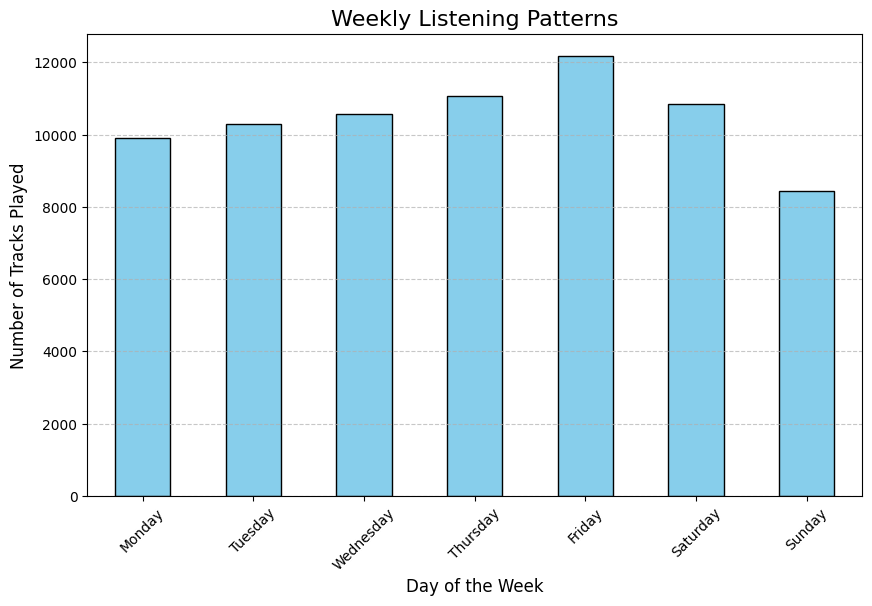

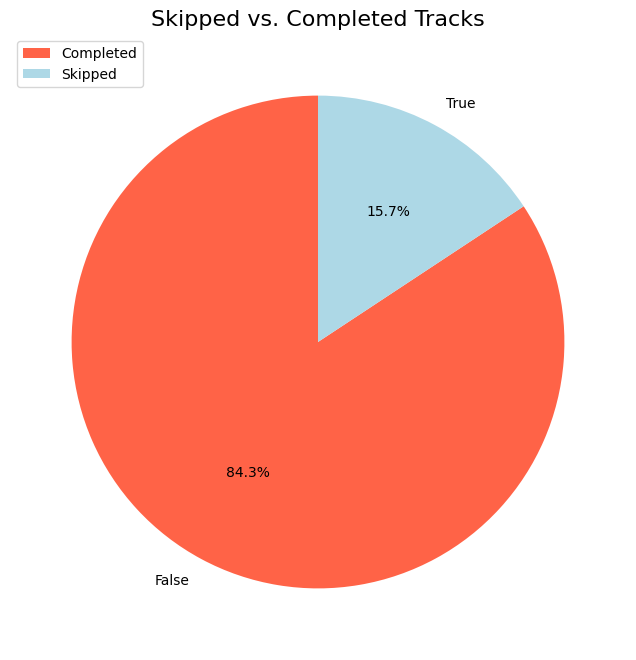

In [34]:
# Weekly listening patterns
weekly_listening = cleaned_df.groupby("day_of_week").size().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Platform usage statistics
platform_usage = cleaned_df["platform"].value_counts()

# Skipped vs. completed tracks
skipped_tracks = cleaned_df["skipped"].value_counts()

# Weekly listening patterns
plt.figure(figsize=(10, 6))
weekly_listening.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Weekly Listening Patterns", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Number of Tracks Played", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Skipped vs. Completed
plt.figure(figsize=(8, 8))
skipped_tracks.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=["tomato", "lightblue"])
plt.title("Skipped vs. Completed Tracks", fontsize=16)
plt.ylabel("")  # Remove the default label
plt.legend(labels=["Completed", "Skipped"], loc="upper left")
plt.show()


In [33]:
# Summary data
{
    "weekly_listening": weekly_listening,
    "platform_usage": platform_usage,
    "skipped_tracks": skipped_tracks,
}

{'weekly_listening': day_of_week
 Monday        9900
 Tuesday      10290
 Wednesday    10566
 Thursday     11067
 Friday       12178
 Saturday     10847
 Sunday        8445
 dtype: int64,
 'platform_usage': platform
 ios                                                                                19003
 iOS 14.8.1 (iPhone9,4)                                                             10274
 windows                                                                             8288
 iOS 11.3.1 (iPhone7,1)                                                              6535
 Windows 10 (10.0.18363; x64)                                                        6352
 iOS 9.3.2 (iPhone7,1)                                                               3806
 osx                                                                                 2537
 Windows 10 (10.0.19044; x64; AppX)                                                  2451
 OS X 10.15.5 [x86 8]                                           

<ipython-input-30-6c352043f5fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['hour_of_day'] = cleaned_df['ts'].dt.hour
<ipython-input-30-6c352043f5fa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['session_gap'] = cleaned_df['ts'].diff().dt.total_seconds()
<ipython-input-30-6c352043f5fa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

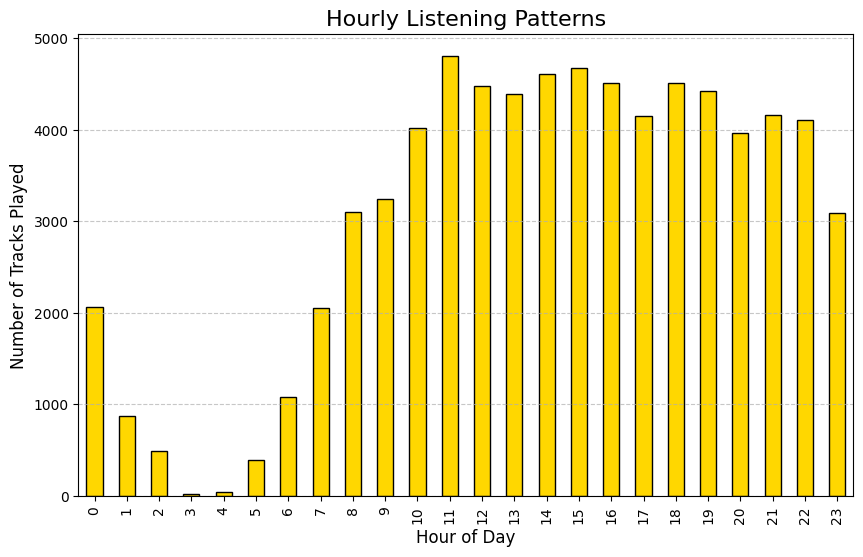

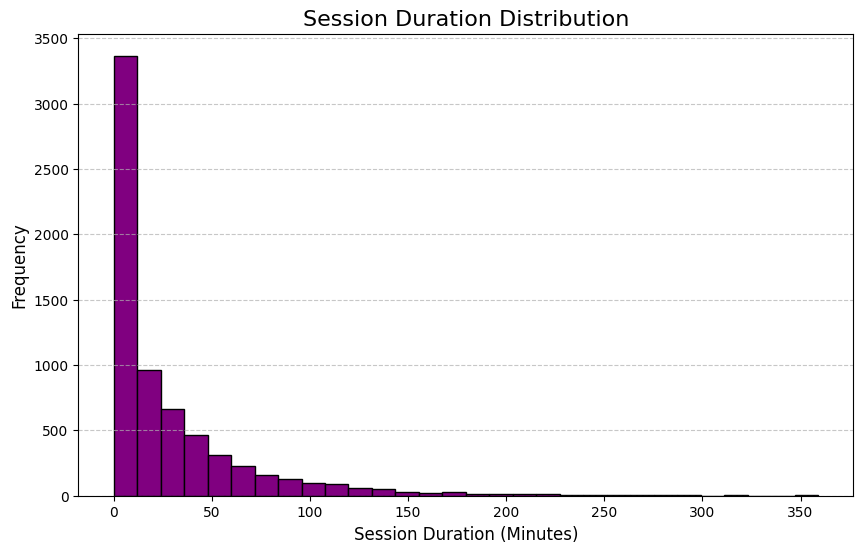

In [30]:
# Listening trends by hour of the day
cleaned_df["hour_of_day"] = cleaned_df["ts"].dt.hour
hourly_listening = cleaned_df.groupby("hour_of_day").size()

# Top artists by day of the week
top_artists_by_day = cleaned_df.groupby(["day_of_week", "master_metadata_album_artist_name"]).size()
top_artists_by_day = top_artists_by_day.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)

# Average session duration (grouping by timestamp gaps)
cleaned_df["session_gap"] = cleaned_df["ts"].diff().dt.total_seconds()
session_threshold = 1800  # 30 minutes threshold for new sessions
cleaned_df["new_session"] = cleaned_df["session_gap"] > session_threshold
session_ids = cleaned_df["new_session"].cumsum()
session_durations = cleaned_df.groupby(session_ids)["ms_played"].sum() / (1000 * 60)  # in minutes

# Hourly listening patterns graph
plt.figure(figsize=(10, 6))
hourly_listening.plot(kind="bar", color="gold", edgecolor="black")
plt.title("Hourly Listening Patterns", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Tracks Played", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Session duration distribution graph
plt.figure(figsize=(10, 6))
session_durations.plot(kind="hist", bins=30, color="purple", edgecolor="black")
plt.title("Session Duration Distribution", fontsize=16)
plt.xlabel("Session Duration (Minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [31]:
# Summary data for artist and session trends
{
    "hourly_listening": hourly_listening.describe(),
    "top_artists_by_day": top_artists_by_day.head(15),
    "session_duration_stats": session_durations.describe(),
}

{'hourly_listening': count      24.000000
 mean     3053.875000
 std      1692.283261
 min        26.000000
 25%      1809.750000
 50%      3992.500000
 75%      4440.250000
 max      4809.000000
 dtype: float64,
 'top_artists_by_day': day_of_week  master_metadata_album_artist_name
 Friday       Hayko Cepkin                         569
              Nightwish                            406
              Epica                                388
 Monday       Hayko Cepkin                         639
              Rammstein                            352
              Nightwish                            325
 Saturday     Hayko Cepkin                         427
              Rammstein                            301
              Nightwish                            294
 Sunday       Hayko Cepkin                         496
              Rammstein                            284
              Nightwish                            194
 Thursday     Hayko Cepkin                         827
  

In [37]:
# Count the occurrences of each track
track_counts = df["master_metadata_track_name"].value_counts()

# Filter for tracks played only once
one_time_tracks = track_counts[track_counts == 1]

print("Tracks listened to only once:")
print(one_time_tracks)

one_time_tracks.to_csv("one_time_tracks.csv", header=True)

Tracks listened to only once:
master_metadata_track_name
Ribs                                                              1
Gunny                                                             1
Paint The Town Blue (from the series Arcane League of Legends)    1
Perpetual Burn                                                    1
Crystal Mountain                                                  1
                                                                 ..
Love You to Death                                                 1
Red Right Hand - 2011 Remastered Version                          1
Vampiria                                                          1
The Mighty Factory of Death                                       1
Glorious                                                          1
Name: count, Length: 4799, dtype: int64


Analyzing year by year

In [24]:
df = combined_streaming_history

# Convert "ts" to datetime
df["ts"] = pd.to_datetime(df["ts"])

# Extract the year from the timestamp
df["year"] = df["ts"].dt.year

years = sorted(df["year"].unique())
analysis_results = {}

for year in years:
    print(f"\n=== Analysis for {year} ===")
    # Subset data for the year
    year_df = df[df["year"] == year]

    # Handle missing values
    missing_values = year_df.isnull().sum()

    # Remove rows where critical columns are missing
    cleaned_year_df = year_df.dropna(subset=["master_metadata_track_name", "master_metadata_album_artist_name"])

    # Calculate top artists
    top_artists = cleaned_year_df["master_metadata_album_artist_name"].value_counts().head(10)

    # Calculate top tracks
    top_tracks = cleaned_year_df["master_metadata_track_name"].value_counts().head(10)

    # Calculate daily play count
    daily_play_count = cleaned_year_df.groupby(cleaned_year_df["ts"].dt.date).size()

    # Calculate total listening duration in hours
    total_duration = cleaned_year_df["ms_played"].sum() / (1000 * 60 * 60)  # in hours

    analysis_results[year] = {
        "missing_values": missing_values,
        "top_artists": top_artists,
        "top_tracks": top_tracks,
        "daily_play_count_stats": daily_play_count.describe(),
        "total_duration_hours": total_duration,
    }

    # Display results for the year
    print("Missing Values:")
    print(missing_values)
    print("\nTop Artists:")
    print(top_artists)
    print("\nTop Tracks:")
    print(top_tracks)
    print("\nDaily Play Count Statistics:")
    print(daily_play_count.describe())
    print(f"\nTotal Listening Duration: {total_duration:.2f} hours")


=== Analysis for 2016 ===
Missing Values:
ts                                      0
platform                                0
ms_played                               0
conn_country                            0
ip_addr                                 0
master_metadata_track_name              0
master_metadata_album_artist_name       0
master_metadata_album_album_name        0
spotify_track_uri                       0
episode_name                         2965
episode_show_name                    2965
spotify_episode_uri                  2965
reason_start                            0
reason_end                              0
shuffle                                 0
skipped                                 0
offline                                 0
offline_timestamp                    1959
incognito_mode                          0
date                                    0
time                                    0
day_of_week                             0
hour_of_day                      

In [36]:
# Analyze biggest listening day for each year
years = sorted(df["year"].unique())
biggest_days = {}

for year in years:
    # Subset data for the year
    year_df = df[df["year"] == year]

    # Group by date and calculate total playtime in minutes
    daily_playtime = year_df.groupby("date")["ms_played"].sum() / (1000 * 60)

    # Find the date with the maximum playtime
    max_day = daily_playtime.idxmax()
    max_minutes = daily_playtime.max()


    biggest_days[year] = {"date": max_day, "total_minutes": max_minutes}

    print(f"{year}: Biggest Listening Day: {max_day}, Total Minutes: {max_minutes:.2f}")



2016: Biggest Listening Day: 2016-07-27, Total Minutes: 127.40
2017: Biggest Listening Day: 2017-08-03, Total Minutes: 276.13
2018: Biggest Listening Day: 2018-06-21, Total Minutes: 222.78
2019: Biggest Listening Day: 2019-08-16, Total Minutes: 157.70
2020: Biggest Listening Day: 2020-03-26, Total Minutes: 209.27
2021: Biggest Listening Day: 2021-12-30, Total Minutes: 626.55
2022: Biggest Listening Day: 2022-01-30, Total Minutes: 694.95
2023: Biggest Listening Day: 2023-03-12, Total Minutes: 454.44
2024: Biggest Listening Day: 2024-06-27, Total Minutes: 482.16


## Hypothesis Testing

### Testing Yearly Change in Listening Times




Hypothesis: There is no significant change in the total listening time between years.

Null Hypothesis: There is no significant difference in the total listening time between years.

Alternative Hypothesis: There is a significant difference in the total listening time between years.

One-way ANOVA is used

In [40]:
data= combined_streaming_history

data["year"] = pd.to_datetime(data["ts"]).dt.year


yearly_listening_time = data.groupby("year")["ms_played"].sum().reset_index()
print(yearly_listening_time)

# listening times grouped by year
listening_times_by_year = [data[data["year"] == year]["ms_played"] for year in yearly_listening_time["year"]]

# one-way ANOVA
anova_result = f_oneway(*listening_times_by_year)

# ANOVA result
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Interpret the result
if anova_result.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in listening times across years.")
else:
    print("Fail to reject the null hypothesis: No significant difference in listening times across years.")

   year   ms_played
0  2016   200945659
1  2017   495766758
2  2018   577453885
3  2019   374201459
4  2020   884962006
5  2021  1432779087
6  2022  3570048334
7  2023  2679225305
8  2024  1378048223
ANOVA F-statistic: 264.5919054015255
ANOVA p-value: 0.0
Reject the null hypothesis: There is a significant difference in listening times across years.


### Testing Shuffle vs. Non-Shuffle Listening Behavior


Null Hypothesis: There is no significant difference in listening times between shuffle and non-shuffle modes.

Alternative Hypothesis: There is a significant difference in listening times.

Normality test to decide between a parametric (two-sample t-test) or non-parametric (Mann-Whitney U test) approach.

In [43]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

data = combined_streaming_history

# Separate data by shuffle mode
shuffle_data = data[data["shuffle"] == True]["ms_played"]
non_shuffle_data = data[data["shuffle"] == False]["ms_played"]

# Check normality for both groups
shapiro_shuffle = shapiro(shuffle_data)
shapiro_non_shuffle = shapiro(non_shuffle_data)

print("Shapiro-Wilk Test for Shuffle Data: \n", shapiro_shuffle)
print("Shapiro-Wilk Test for Non-Shuffle Data: \n", shapiro_non_shuffle)

# Decide the test based on normality
if shapiro_shuffle.pvalue > 0.05 and shapiro_non_shuffle.pvalue > 0.05:
    # normal, perform a two-sample t-test
    test_result = ttest_ind(shuffle_data, non_shuffle_data)
    print("Two-sample t-test Results: \n", test_result)
else:
    # non-normal, perform Mann-Whitney U test
    test_result = mannwhitneyu(shuffle_data, non_shuffle_data, alternative="two-sided")
    print("Mann-Whitney U Test Results: \n ", test_result)

if test_result.pvalue < 0.05:
    print("\n Reject the null hypothesis: Significant difference in listening times between shuffle and non-shuffle modes.")
else:
    print("\n Fail to reject the null hypothesis: No significant difference in listening times between shuffle and non-shuffle modes.")

Shapiro-Wilk Test for Shuffle Data: 
 ShapiroResult(statistic=0.8164434753211628, pvalue=9.851272821655576e-56)
Shapiro-Wilk Test for Non-Shuffle Data: 
 ShapiroResult(statistic=0.7798171892994101, pvalue=4.8297992444017005e-126)
Mann-Whitney U Test Results: 
  MannwhitneyuResult(statistic=114334152.5, pvalue=3.980593207000422e-86)

 Reject the null hypothesis: Significant difference in listening times between shuffle and non-shuffle modes.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69422.
  res = hypotest_fun_out(*samples, **kwds)


### Testing Repeat vs. Unique Listening

Null Hypothesis: There is no significant difference in listening times between repeated and unique tracks.

Alternative Hypothesis: There is a significant difference in listening times between repeated and unique tracks.

Mann-Whitney U test (non-parametric)

In [49]:
data = combined_streaming_history

# Identify repeated and unique tracks based on Spotify track URI
track_play_counts = data["spotify_track_uri"].value_counts()
repeated_tracks = track_play_counts[track_play_counts > 1].index
unique_tracks = track_play_counts[track_play_counts == 1].index

# Separate listening times for repeated and unique tracks
repeated_data = data[data["spotify_track_uri"].isin(repeated_tracks)]["ms_played"]
unique_data = data[data["spotify_track_uri"].isin(unique_tracks)]["ms_played"]

# Perform Mann-Whitney U test
test_result = mannwhitneyu(repeated_data, unique_data, alternative="two-sided")

# Calculate descriptive statistics
repeated_mean = repeated_data.mean()
unique_mean = unique_data.mean()

repeated_median = repeated_data.median()
unique_median = unique_data.median()


print("Repeated Tracks:")
print(f"Mean Listening Time: {repeated_mean}")
print(f"Median Listening Time: {repeated_median}\n")

print("Unique Tracks:")
print(f"Mean Listening Time: {unique_mean}")
print(f"Median Listening Time: {unique_median}\n")

if test_result.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in listening times between repeated and unique tracks.")
else:
    print("Fail to reject the null hypothesis: No significant difference in listening times between repeated and unique tracks.")

Repeated Tracks:
Mean Listening Time: 164302.9549850147
Median Listening Time: 175162.0

Unique Tracks:
Mean Listening Time: 53362.358273381295
Median Listening Time: 10991.5

Reject the null hypothesis: There is a significant difference in listening times between repeated and unique tracks.


## Analyzing Listening Patterns - ML

### A classifier attempt

A classifier trying to predict the platform a I am using based on:

- Listening hour (hour): The hour of the day when the listening session occurred.
- Day of the week (day_of_week_encoded): Encoded day of the week when the session occurred.
- Listening duration (duration_min): Total duration of the listening session in minutes.
- Time block (time_block): A feature combining the hour and the day of the week into a coarser time frame (e.g., morning on Monday).

Uses SMOTE to oversaple the minority classes and XGBOOST as the base classifier.

In [72]:
from sklearn.utils import resample
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


df = combined_streaming_history.copy()

# Convert timestamp to datetime
df["ts"] = pd.to_datetime(df["ts"])

# Extract useful time-based features
df["hour"] = df["ts"].dt.hour
df["day_of_week"] = df["ts"].dt.day_name()

# Clean and Aggregate Platforms
df["platform"] = df["platform"].str.split(" ").str[0]
df["platform"] = df["platform"].str.lower()
df["platform"] = df["platform"].replace({
    "osx": "os",
    "windows": "windows",
    "ios": "ios"
})

# Calculate session duration in minutes
df["duration_min"] = df["ms_played"] / 60000

# Drop unnecessary columns
columns_to_keep = ["hour", "day_of_week", "platform", "duration_min"]
df = df[columns_to_keep]

# Encode categorical features
le_platform = LabelEncoder()
df["platform_encoded"] = le_platform.fit_transform(df["platform"])

le_day_of_week = LabelEncoder()
df["day_of_week_encoded"] = le_day_of_week.fit_transform(df["day_of_week"])

df["time_block"] = (df["hour"] // 6) + (df["day_of_week_encoded"] * 4)

# Define features (X) and target (y)
#X = df[["hour", "day_of_week_encoded", "duration_min"]]
X = df[["hour", "day_of_week_encoded", "duration_min", "time_block"]]
y = df["platform_encoded"]

"""
# Oversample classes with less support
balanced_df = pd.DataFrame()
for cls in y.unique():
    class_df = df[df["platform_encoded"] == cls]
    if len(class_df) < y.value_counts().max():
        class_df = resample(class_df, replace=True, n_samples=y.value_counts().max(), random_state=42)
    balanced_df = pd.concat([balanced_df, class_df])

# Finalize balanced dataset
X_balanced = balanced_df[["hour", "day_of_week_encoded", "duration_min"]]
y_balanced = balanced_df["platform_encoded"]
"""

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Validate dataset balance
print("Balanced dataset class counts:")
print(y_balanced.value_counts())


<ipython-input-72-a0a035365917>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['platform_encoded'] = le_platform.fit_transform(df['platform'])
<ipython-input-72-a0a035365917>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week_encoded'] = le_day_of_week.fit_transform(df['day_of_week'])
<ipython-input-72-a0a035365917>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Balanced dataset class counts:
platform_encoded
0    42443
3    42443
1    42443
2    42443
Name: count, dtype: int64


In [73]:
from sklearn.model_selection import RandomizedSearchCV

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train XGBoost Classifier
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_platform.classes_))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:50:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

         ios       0.53      0.46      0.49      8500
          os       0.56      0.47      0.51      8376
     partner       0.66      0.90      0.76      8694
     windows       0.57      0.50      0.53      8385

    accuracy                           0.59     33955
   macro avg       0.58      0.59      0.57     33955
weighted avg       0.58      0.59      0.58     33955



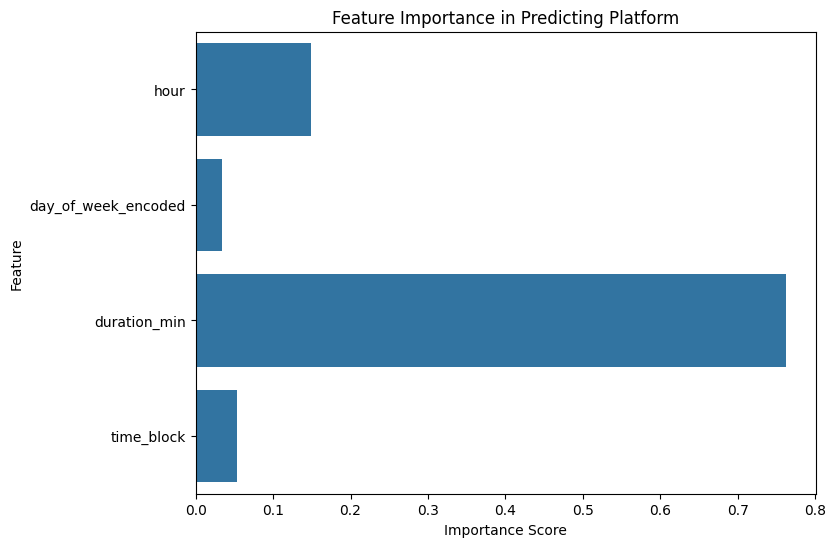

In [74]:
# Feature Importance
plt.figure(figsize=(8, 6))
sns.barplot(x=clf.feature_importances_, y=X.columns)
plt.title("Feature Importance in Predicting Platform")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

#### With 5-Fold Cross Validation

In [75]:
# Define k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score, average="macro"),
    "f1": make_scorer(f1_score, average="macro")
}

# Perform cross-validation
scores = {metric: [] for metric in scoring.keys()}
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    clf.fit(X_train, y_train)

    # Predict and evaluate on the test set
    y_pred = clf.predict(X_test)
    scores["accuracy"].append(accuracy_score(y_test, y_pred))
    scores["precision"].append(precision_score(y_test, y_pred, average="macro"))
    scores["recall"].append(recall_score(y_test, y_pred, average="macro"))
    scores["f1"].append(f1_score(y_test, y_pred, average="macro"))

# Display results
print(f"Cross-Validation Results ({k}-fold):")
for metric, values in scores.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

Cross-Validation Results (5-fold):
Accuracy: 0.5643 ± 0.0015
Precision: 0.3654 ± 0.0042
Recall: 0.3638 ± 0.0059
F1: 0.3645 ± 0.0050


## Time Series Analysis and Forecasting

The goal is to capture and predict listening habits or trends over time.

For this purpose a time-series model prohet is used to forecast future listenning patters

In [7]:
!pip install prophet

In [28]:
from prophet import Prophet

#Aggregate Listening Data by Day
df["ts"] = pd.to_datetime(df["ts"])
df["duration_min"] = df["ms_played"] / 60000

# Aggregate daily total listening duration
daily_data = df.groupby(df["ts"].dt.date).agg({"duration_min": "sum"}).reset_index()
daily_data.columns = ["ds", "y"]


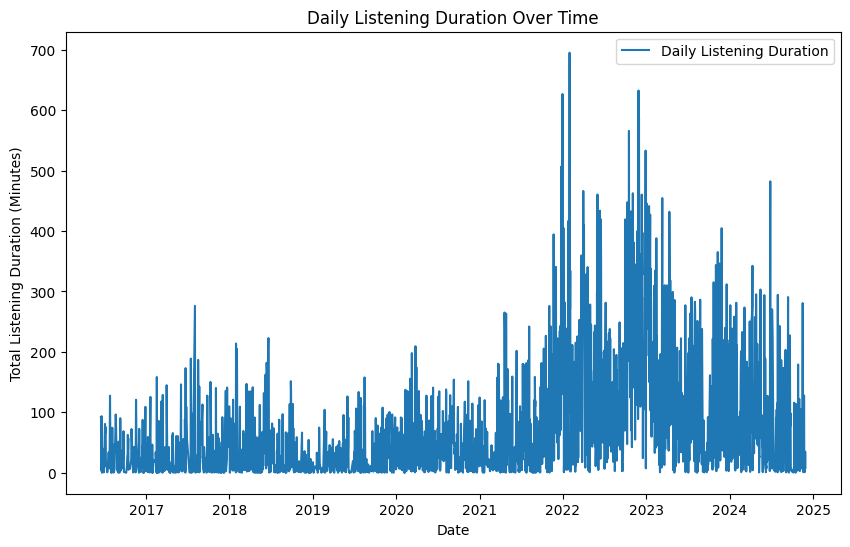

In [29]:
#Visualize the Data
plt.figure(figsize=(10, 6))
plt.plot(daily_data["ds"], daily_data["y"], label="Daily Listening Duration")
plt.title("Daily Listening Duration Over Time")
plt.xlabel("Date")
plt.ylabel("Total Listening Duration (Minutes)")
plt.legend()
plt.show()

Steady Growth (2016–2021):

- From 2016 to around 2021, there is a steady increase in daily listening duration. This indicates a gradual growth in my engagement with music over the years.

Peak Engagement (2022):

- In 2022, there is a noticeable spike in daily listening duration, with some days exceeding 600 minutes (~10 hours).

Stabilization (2023–2024):

- Post-2022, my listening duration stabilizes at a lower but still consistent level, indicating a more regular listening habit compared to the peak in 2022.


In [41]:
#Train Prophet Model
model = Prophet()
model.fit(daily_data)

#Make Future Predictions
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/cm3th1dm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/nft_axyl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68389', 'data', 'file=/tmp/tmps4zevdbc/cm3th1dm.json', 'init=/tmp/tmps4zevdbc/nft_axyl.json', 'output', 'file=/tmp/tmps4zevdbc/prophet_modelve5rs1vq/prophet_model-20250109145839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:58:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

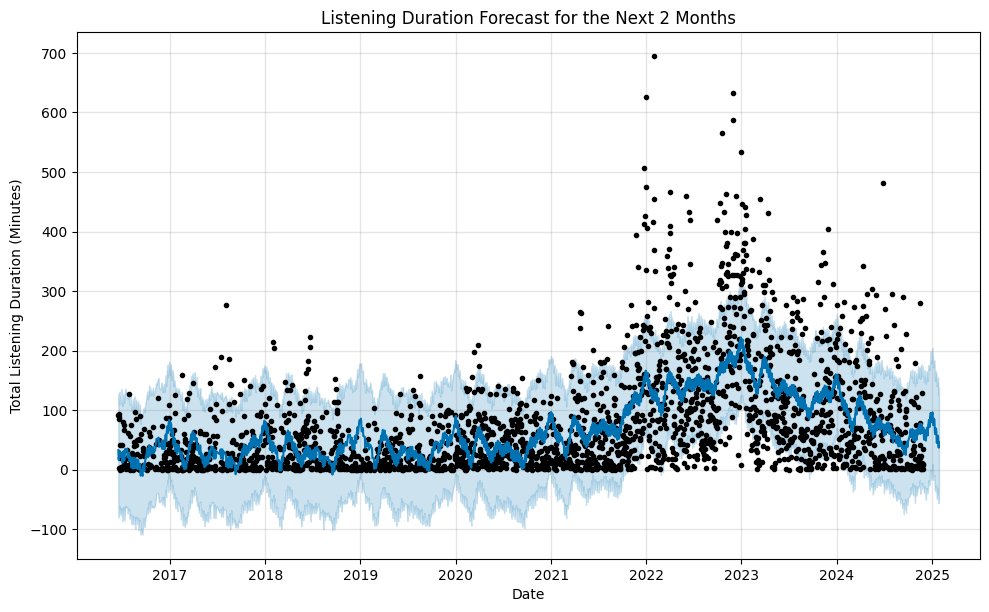

In [42]:
# Visualize the forecast
plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title("Listening Duration Forecast for the Next 2 Months")
plt.xlabel("Date")
plt.ylabel("Total Listening Duration (Minutes)")
plt.show()

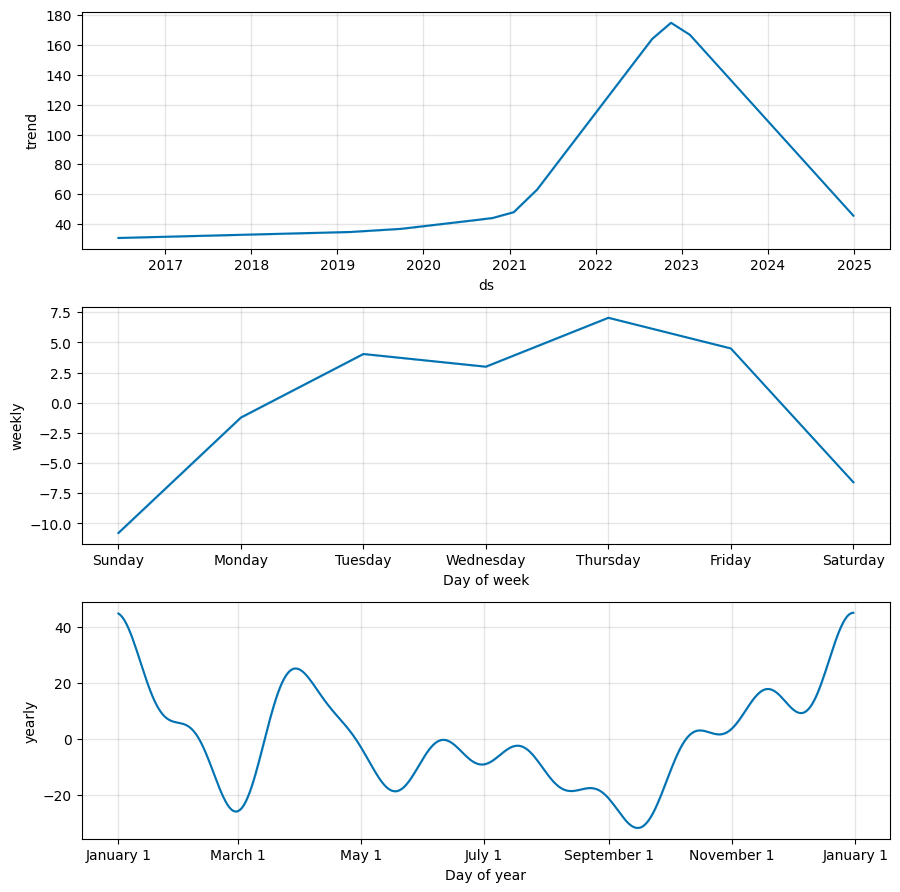

In [32]:
#isualize Forecast Components
model.plot_components(forecast)
plt.show()

These plots show the decomposition of my listening behavior into trend, weekly seasonality, and yearly seasonality using the Prophet model"s method.

The second graph shows the weekly seasonality. Listening activity is lowest on Sundays, with a significant increase starting on Monday untill it peaks on Thursday, followed by a decline toward Friday and Saturday.
- Weekdays (Monday–Thursday) are my most active listening days, possibly tied to my structured routines like study.
- Weekends (Saturday–Sunday) see a drop, likely due to changes in routine or more outdoor activities.

The third graph shows the yearly seasonality. Listening duration peaks during the end of the year (December) and the beginning of the year (January). Might be because of the holiday season. There is a dip in listening activity around June to September. Minor increases in listening activity around March and October align with transitional periods between seasons.

Which session type contributes most to the listening duration

In [63]:
from datetime import timedelta

data = combined_streaming_history


# Data Preprocessing
data["ts"] = pd.to_datetime(data["ts"])

# Sort by timestamp to ensure chronological order
data = data.sort_values(by="ts")

# Create sessions by identifying gaps between tracks
session_gap = timedelta(minutes=30)
data["session_id"] = (data["ts"] - data["ts"].shift(1) > session_gap).cumsum()

# Calculate total listening time per session
session_stats = data.groupby("session_id").agg(
    session_start=("ts", "min"),
    session_end=("ts", "max"),
    total_listening_time=("ms_played", lambda x: x.sum() / 60000)
).reset_index()

# Classify sessions into categories based on listening time
def classify_session(duration):
    if duration < 30:
        return "Short"
    elif duration < 90:
        return "Medium"
    else:
        return "Long"

session_stats["session_type"] = session_stats["total_listening_time"].apply(classify_session)

# Merge session data back into the main DataFrame
data = pd.merge(data, session_stats[["session_id", "session_type"]], on="session_id", how="left")

# Drop or rename duplicate columns
data = data.rename(columns={"session_type_y": "session_type"}).drop(columns=["session_type_x"])

# Aggregate daily listening duration by session type
daily_session_data = data.groupby([data["ts"].dt.date, "session_type"]).agg(
    total_listening_time=("ms_played", lambda x: x.sum() / 60000)  # Convert ms to minutes
).reset_index()

daily_session_data.columns = ["ds", "session_type", "y"]



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/bik1_vwb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/g0jwwjf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29312', 'data', 'file=/tmp/tmps4zevdbc/bik1_vwb.json', 'init=/tmp/tmps4zevdbc/g0jwwjf0.json', 'output', 'file=/tmp/tmps4zevdbc/prophet_modelsnr7k6x4/prophet_model-20250109154823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

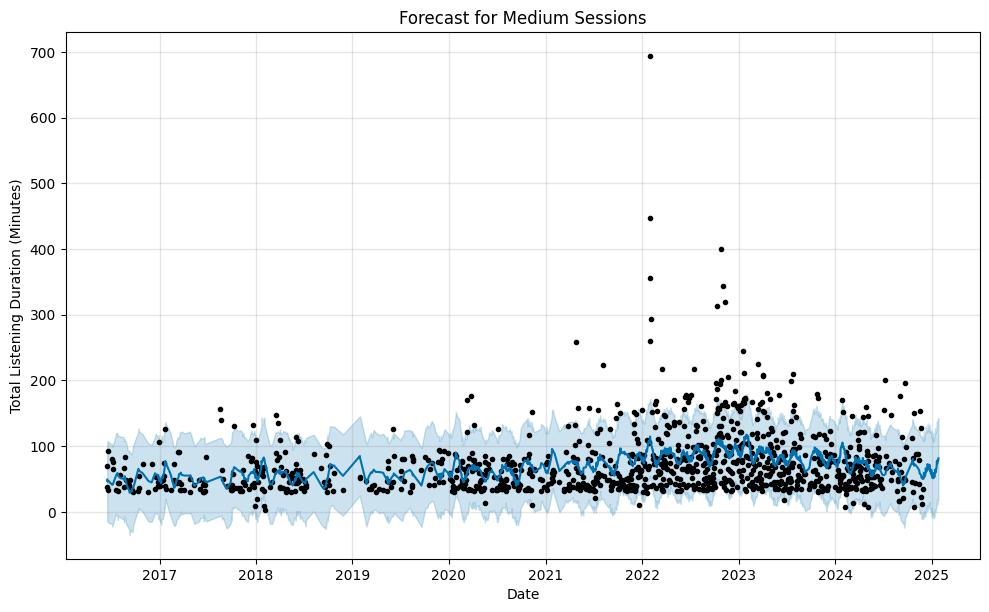

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/ht_igi0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/8yuow4tj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82121', 'data', 'file=/tmp/tmps4zevdbc/ht_igi0x.json', 'init=/tmp/tmps4zevdbc/8yuow4tj.json', 'output', 'file=/tmp/tmps4zevdbc/prophet_modelkf0nsz48/prophet_model-20250109154825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

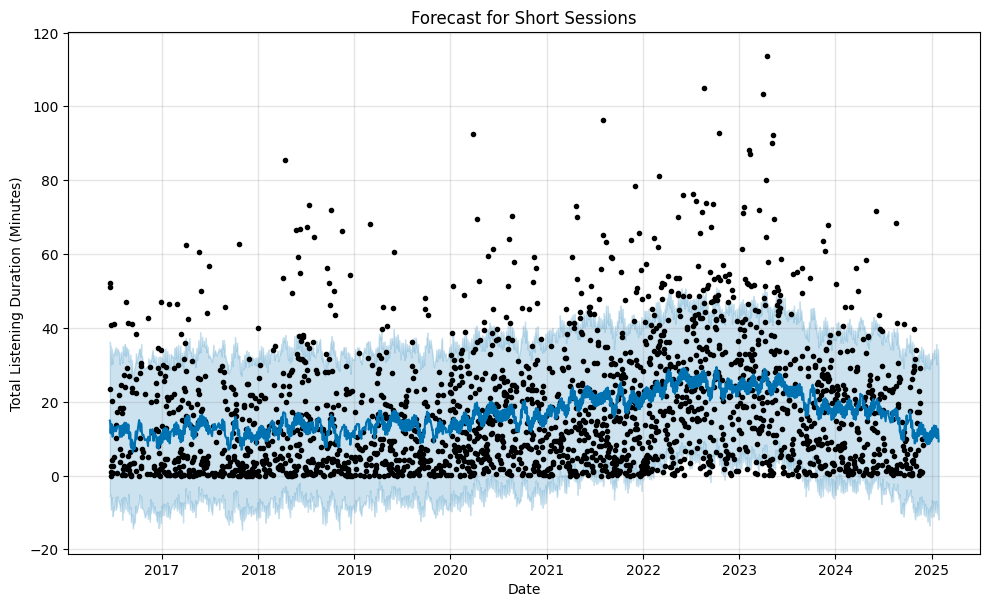

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/6hxtbl9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps4zevdbc/lu8jho8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4440', 'data', 'file=/tmp/tmps4zevdbc/6hxtbl9z.json', 'init=/tmp/tmps4zevdbc/lu8jho8b.json', 'output', 'file=/tmp/tmps4zevdbc/prophet_model_wi7m7g_/prophet_model-20250109154826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

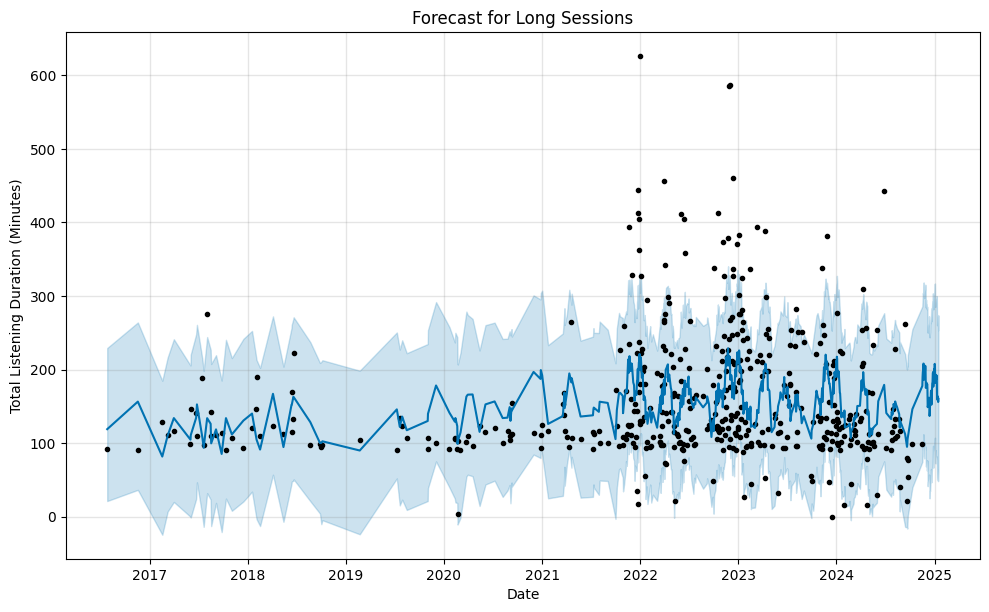

In [64]:
# Forecast for each session type
session_types = daily_session_data["session_type"].unique()
forecast_results = {}

for session_type in session_types:

    session_data = daily_session_data[daily_session_data["session_type"] == session_type]

    # Train Prophet model
    model = Prophet()
    model.fit(session_data)

    # Make future predictions
    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)

    # Store the forecast
    forecast_results[session_type] = forecast

    # Plot the forecast for this session type
    plt.figure(figsize=(12, 6))
    model.plot(forecast)
    plt.title(f"Forecast for {session_type} Sessions")
    plt.xlabel("Date")
    plt.ylabel("Total Listening Duration (Minutes)")
    plt.show()


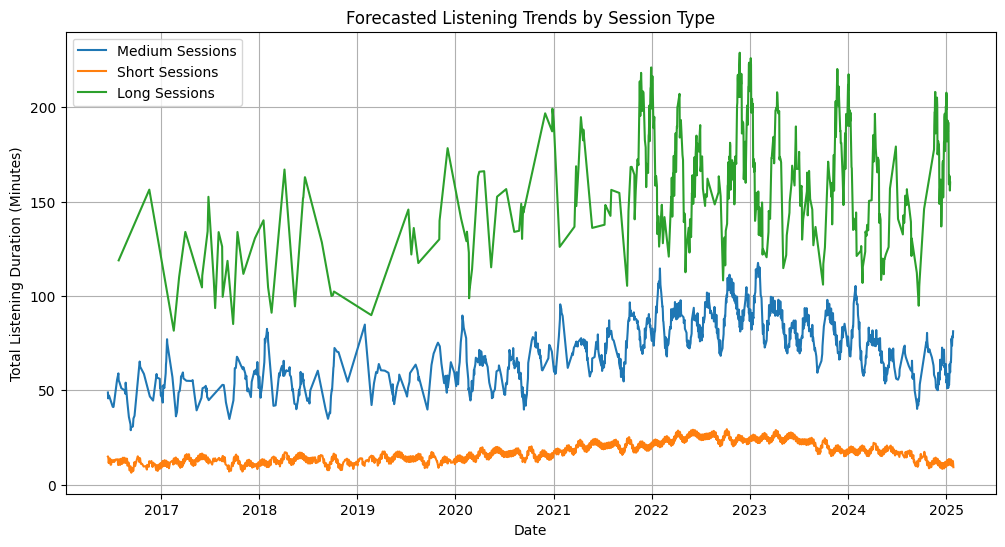

In [65]:
# Combine and compare forecasts
plt.figure(figsize=(12, 6))
for session_type, forecast in forecast_results.items():
    plt.plot(forecast["ds"], forecast["yhat"], label=f"{session_type} Sessions")

plt.title("Forecasted Listening Trends by Session Type")
plt.xlabel("Date")
plt.ylabel("Total Listening Duration (Minutes)")
plt.legend()
plt.grid()
plt.show()

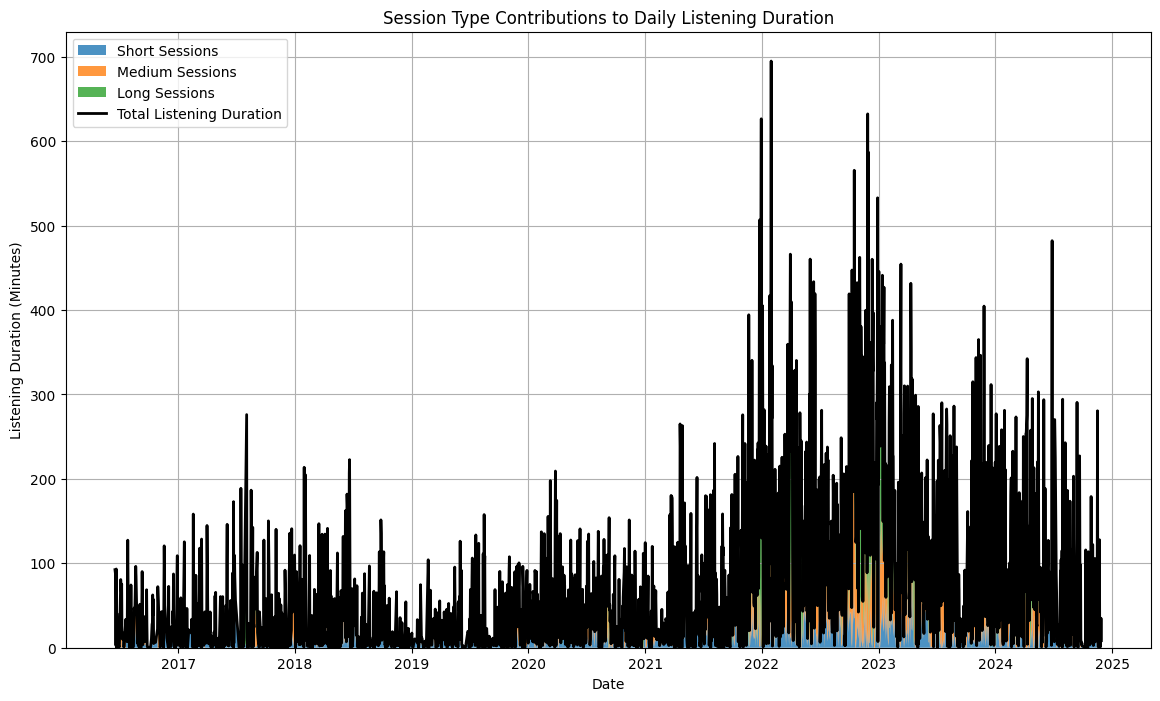

In [66]:
import matplotlib.pyplot as plt


daily_session_data = data.groupby([data["ts"].dt.date, "session_type"]).agg(
    total_listening_time=("ms_played", lambda x: x.sum() / 60000)
).reset_index()
daily_session_data.columns = ["date", "session_type", "total_listening_time"]


pivoted_data = daily_session_data.pivot(index="date", columns="session_type", values="total_listening_time")
pivoted_data.fillna(0, inplace=True)
pivoted_data["Total"] = pivoted_data.sum(axis=1)

# Plot the contributions of session types
plt.figure(figsize=(14, 8))
plt.stackplot(
    pivoted_data.index,
    pivoted_data["Short"],
    pivoted_data["Medium"],
    pivoted_data["Long"],
    labels=["Short Sessions", "Medium Sessions", "Long Sessions"],
    alpha=0.8
)
plt.plot(pivoted_data.index, pivoted_data["Total"], color="black", linewidth=2, label="Total Listening Duration")
plt.title("Session Type Contributions to Daily Listening Duration")
plt.xlabel("Date")
plt.ylabel("Listening Duration (Minutes)")
plt.legend(loc="upper left")
plt.grid()
plt.show()


Short Sessions (blue) dominate the listening duration in earlier years (pre-2020). Their contribution is more consistent across time, indicating that short, frequent listening habits are more stable.

Medium Sessions (orange) begin to increase in contribution post-2020, particularly during periods of high total listening duration (2022 and 2023).

Long Sessions (green) are rare but are visible in periods of higher total duration. This suggests they are not common but contribute significantly during listening spikes.

Short Sessions show consistent contributions, while Medium and Long Sessions are more variable and appear to be associated with significant peaks or dips in total listening duration.

Which session types dominate during specific periods or patterns:

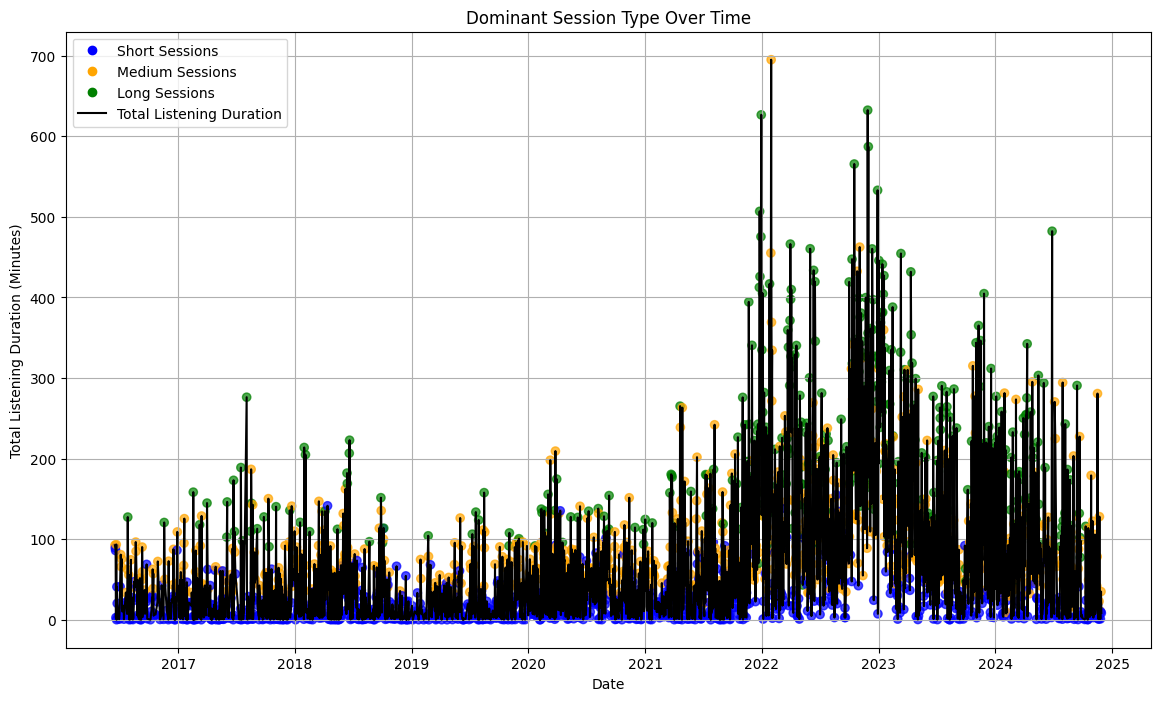

Dominant session types counts:
Dominant
Short     1225
Medium     862
Long       404
Name: count, dtype: int64
Monthly dominant session type:
Month
1     Short
2     Short
3     Short
4     Short
5     Short
6     Short
7     Short
8     Short
9     Short
10    Short
11    Short
12    Short
Name: Dominant, dtype: object


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta



data = combined_streaming_history

# Create sessions by identifying gaps between tracks
session_gap = timedelta(minutes=30)
data["ts"] = pd.to_datetime(data["ts"])
data = data.sort_values(by="ts")
data["session_id"] = (data["ts"] - data["ts"].shift(1) > session_gap).cumsum()

# Calculate session statistics and classify sessions
session_stats = data.groupby("session_id").agg(
    total_listening_time=("ms_played", lambda x: x.sum() / 60000)
).reset_index()

def classify_session(duration):
    if duration < 30:
        return "Short"
    elif duration < 90:
        return "Medium"
    else:
        return "Long"

session_stats["session_type"] = session_stats["total_listening_time"].apply(classify_session)
data = pd.merge(data, session_stats[["session_id", "session_type"]], on="session_id", how="left", validate="many_to_one")

data.rename(columns={"session_type_y": "session_type"}, inplace=True)
data.drop(columns=["session_type_x"], inplace=True)  # Optional: drop the redundant column

# Aggregate daily listening duration by session type
daily_session_data = data.groupby([data["ts"].dt.date, "session_type"]).agg(
    total_listening_time=("ms_played", lambda x: x.sum() / 60000)  # Convert ms to minutes
).reset_index()
daily_session_data.columns = ["date", "session_type", "total_listening_time"]

# Pivot data to get session types as columns
pivoted_data = daily_session_data.pivot(index="date", columns="session_type", values="total_listening_time").fillna(0)
pivoted_data["Total"] = pivoted_data.sum(axis=1)  # Calculate total listening duration per day

# Determine the dominant session type for each day
pivoted_data["Dominant"] = pivoted_data[["Short", "Medium", "Long"]].idxmax(axis=1)

# Visualize dominance over time
plt.figure(figsize=(14, 8))
plt.scatter(
    pivoted_data.index,
    pivoted_data["Total"],
    c=pivoted_data["Dominant"].map({"Short": "blue", "Medium": "orange", "Long": "green"}),
    label="Dominant Session Type",
    alpha=0.7
)
plt.plot(pivoted_data.index, pivoted_data["Total"], color="black", linewidth=1.5, label="Total Listening Duration")
plt.title("Dominant Session Type Over Time")
plt.xlabel("Date")
plt.ylabel("Total Listening Duration (Minutes)")
plt.legend(handles=[
    plt.Line2D([0], [0], color="blue", marker="o", label="Short Sessions", linestyle="None"),
    plt.Line2D([0], [0], color="orange", marker="o", label="Medium Sessions", linestyle="None"),
    plt.Line2D([0], [0], color="green", marker="o", label="Long Sessions", linestyle="None"),
    plt.Line2D([0], [0], color="black", label="Total Listening Duration")
], loc="upper left")
plt.grid()
plt.show()

# Analyze patterns
dominant_counts = pivoted_data["Dominant"].value_counts()
print("Dominant session types counts:")
print(dominant_counts)

# Group by month or season for pattern analysis
pivoted_data["Month"] = pd.to_datetime(pivoted_data.index).month
monthly_dominance = pivoted_data.groupby("Month")["Dominant"].apply(lambda x: x.mode()[0])
print("Monthly dominant session type:")
print(monthly_dominance)


Short sessions dominate with 1,225 days, significantly more than Medium (862 days) and Long sessions (404 days).

- This might suggest that most days are characterized by shorter, more casual listening habits, likely consisting of quick songs or brief sessions.


Medium sessions (862 days) are the second most dominant, followed by Long sessions (404 days).

- Medium and Long sessions dominate during peaks, suggesting that extended periods of focused or intentional listening (e.g., playlists, albums, or binge-listening) are rarer but align with high activity days.

The results indicate that Short sessions dominate every month, highlighting their consistency throughout the year.
- This may suggest that daily listening habits are generally characterized by short, sporadic sessions, regardless of seasonal changes.